## Fake Reviews Classification

Dataset Source: https://www.kaggle.com/datasets/razamukhtar007/fake-reviews

#### Import Necessary Libraries

In [1]:
import os, sys, re
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch
from torch import nn

from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptEncoderConfig,
)

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)

          Python : 3.9.12
           NumPy : 1.25.1
           Torch : 2.0.1
    Transformers : 4.31.0
        Datasets : 2.13.1
        Evaluate : 0.4.0


#### Ingest & Preprocess Dataset

In [3]:
data = pd.read_csv("fake_reviews.csv")

data = data.dropna()
data = data.drop_duplicates(subset=['cleaned_review_body'], ignore_index=True)

data['titles'] = data['review_headline'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data['titles'] = data['titles'].str.strip()


data['text'] = data['titles'] + " " + data['cleaned_review_body']

data = data.drop(columns=[
                            "review_headline", 
                            "review_body", 
                            "cleaned_review_body", 
                            "titles"
                        ]
                 )

data = data.rename(
    columns=
    {
        "fake_review": "labels",
        "cleaned_review_body": "reviews",
    }
)

data['labels'] = data['labels'].astype(np.int64)

data

,labels,text
0,0,THESE REALLY DO WORK GREAT WITH SOME TWEAKING ...
1,0,Favorite for winter Very warm love dress absol...
2,0,Great Socks for the money nice sock great colo...
3,0,Slick hat bought husband slick high quality cr...
4,0,I would do it again perfect dress customer ser...
...,...,...
112624,0,Four Stars work exactly like suppose simple de...
112625,0,For the price it is a good reliable phone for ...
112626,0,Five Stars arrived great condition worth money...
112627,0,Easy to use easy charge multiple device multip...


#### Descriptive Statistics About All Features

In [4]:
data.describe(include='all')

,labels,text
count,112629.000000,112629
unique,NaN,112629
top,NaN,THESE REALLY DO WORK GREAT WITH SOME TWEAKING ...
freq,NaN,1
mean,0.171412,NaN
std,0.376871,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


#### Histogram: Word Count of Titles & Reviews Combined

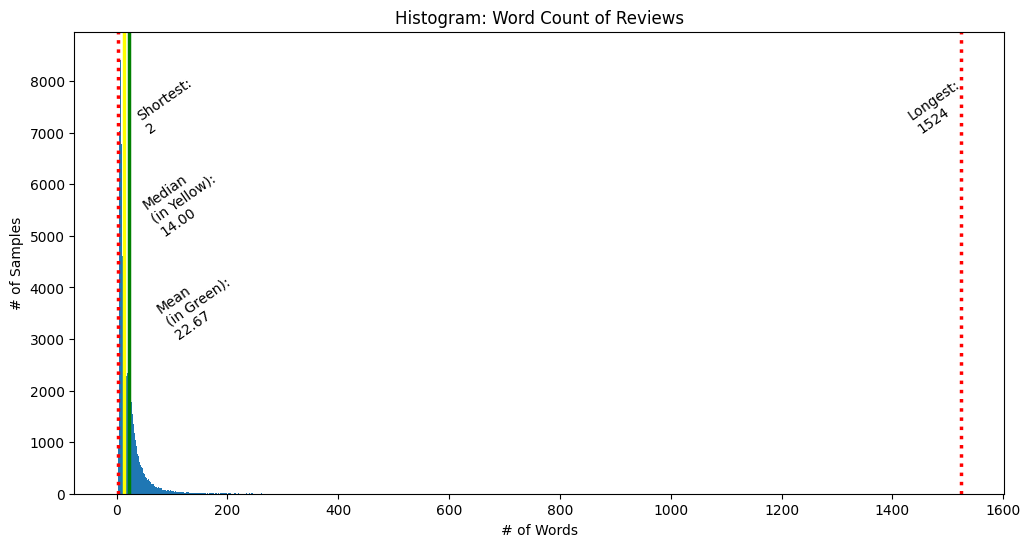

In [5]:
data['word_count'] = data['text'].str.split(" ").str.len()

MIN_INPUT_COUNT = min(data['word_count'])
MAX_INPUT_COUNT = max(data['word_count'])
INPUT_COUNT_MEAN = data['word_count'].mean()
INPUT_COUNT_MEDIAN = data['word_count'].median()

n_bin=MAX_INPUT_COUNT + 1
data.hist('word_count', 
          grid=False, 
          figsize=(12, 6), 
          range=(0,n_bin + 1), 
          bins=n_bin + 1)
plt.title('Histogram: Word Count of Reviews')
plt.xlabel('# of Words')
plt.ylabel('# of Samples')

# Display & label vertical line @ MINIMUM value
plt.axvline(MIN_INPUT_COUNT, color='red', linestyle='dotted', linewidth=2.5)
plt.text(MIN_INPUT_COUNT * 16, 7000, 'Shortest:\n{:.0f}'.format(MIN_INPUT_COUNT), rotation=35)

# Display & label vertical line @ MAXIMUM value
plt.axvline(MAX_INPUT_COUNT, color='red', linestyle='dotted', linewidth=2.5)
plt.text(MAX_INPUT_COUNT - 100, 7000, 'Longest:\n{:.0f}'.format(MAX_INPUT_COUNT), rotation=35)

# Display & label vertical line @ MEAN value
plt.axvline(INPUT_COUNT_MEAN, color='green', linestyle='solid', linewidth=2.5)
plt.text(INPUT_COUNT_MEAN * 3, 3000, 'Mean\n(in Green):\n{:.2f}'.format(INPUT_COUNT_MEAN), rotation=35)

# Display & label vertical line @ MEDIAN value
plt.axvline(INPUT_COUNT_MEDIAN, color='yellow', linestyle='solid', linewidth=2.5)
plt.text(INPUT_COUNT_MEDIAN * 3, 5000, 'Median\n(in Yellow):\n{:.2f}'.format(INPUT_COUNT_MEDIAN), rotation=35)

plt.show()

#### Define Function for Bar Plot Visualization

In [6]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(8,6),
                                                      rot=0,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "brown",
                                                             "lightblue",
                                                             "tan",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red",
                                                             "purple"]
                                                      )

    ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Bar Plot: Class Distribution

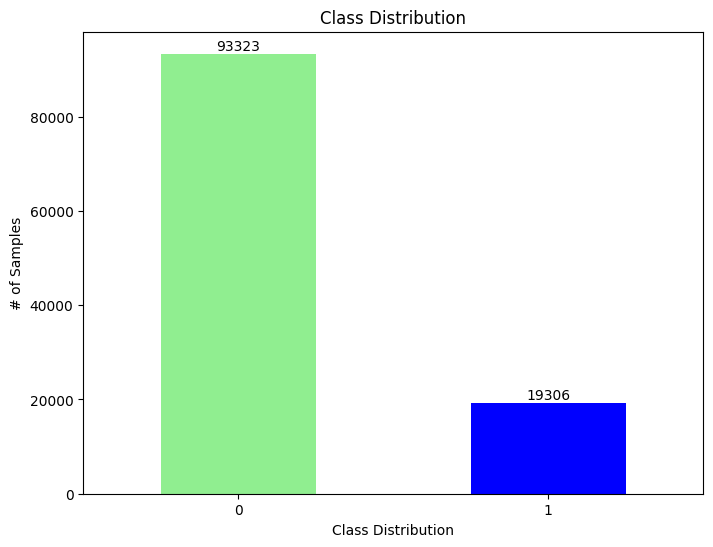

In [7]:
barplot_visual(data["labels"],
               "Class Distribution",
               "Class Distribution",
               "# of Samples",
               )

#### Remove Overly Lengthy Inputs & Unnecessary Features

In [8]:
data = data[data['word_count'] < 121]

data = data.drop(columns=['word_count'])

data = data.reset_index(drop=True)

data.describe(include='all')

,labels,text
count,111331.000000,111331
unique,NaN,111331
top,NaN,Favorite for winter Very warm love dress absol...
freq,NaN,1
mean,0.166836,NaN
std,0.372831,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


#### Convert Pandas DataFrame to Dataset & Split into Training & Testing Datasets

In [9]:
dataset = Dataset.from_pandas(data)

train_test = dataset.train_test_split(test_size=0.25)

ds = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test'],
})

print(f'Training Dataset Shape: {ds["train"].shape}')
print(f'Testing Dataset Shape: {ds["test"].shape}')

Training Dataset Shape: (83498, 2)
Testing Dataset Shape: (27833, 2)


#### Convert Between String & Integer Class Types

In [10]:
unique_label_values = ["Real", "Fake"]

NUM_OF_LABELS = len(unique_label_values)

label2id = {label: idx for idx, label in enumerate(unique_label_values)}
id2label = {idx: label for idx, label in enumerate(unique_label_values)}

print(f"List of Unique Label Values:\n{unique_label_values}")
print(f"Number of Unique Label Values:\n{NUM_OF_LABELS}")
print(f"Converting Label Values From String to Integer:\n{label2id}")
print(f"Converting Label Values From Integer to String:\n{id2label}")

List of Unique Label Values:
['Real', 'Fake']
Number of Unique Label Values:
2
Converting Label Values From String to Integer:
{'Real': 0, 'Fake': 1}
Converting Label Values From Integer to String:
{0: 'Real', 1: 'Fake'}


#### Baisc Values/Constants

In [11]:
MODEL_CKPT = "bert-large-uncased"
MODEL_NAME = f"{MODEL_CKPT.split('/')[-1]}-Fake_Reviews_Classifier"

NUM_OF_EPOCHS = 5
LR = 1e-3

REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01

STRATEGY = "epoch"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_seed = 42

#### Define Tokenizer

In [12]:
if any(k in MODEL_CKPT for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"
    
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                          padding_side=padding_side)

if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
    
def tokenize(samples):
    return tokenizer(samples["text"],
                     truncation=True,
                     max_length=None)

#### Tokenize Entire Dataset

In [13]:
encoded_ds = ds.map(tokenize, 
                    batched=True, 
                    remove_columns=['text'])

encoded_ds['train']

Map:   0%|          | 0/83498 [00:00<?, ? examples/s]

Map:   0%|          | 0/27833 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 83498
})

#### Define Compute Metrics Function

In [14]:
def compute_metrics(p):
    """
    This function takes the predictions output from 
    trainer.evaluate & returns the following metrics:
    - Accuracy
    - F1 (Weighted, Micro, & Macro Averaged)
    - Recall (Weighted, Micro, & Macro Averaged)
    - Precision (Weighted, Micro, & Macro Averaged)
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define Data Collator

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        padding="longest")

#### Define PEFT Configuration

In [16]:
peft_config = PromptEncoderConfig(
    task_type="SEQ_CLS",
    num_virtual_tokens=20,
    encoder_hidden_size=128
)

#### Define Model

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    label2id=label2id,
    id2label=id2label,
    return_dict=True
    ).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Apply PEFT Configuration To Model

In [18]:
model = get_peft_model(model, 
                       peft_config)

model.print_trainable_parameters()

trainable params: 304388 || all params: 335446276 || trainable%: 0.09074120709570793


/Users/briandunn/Desktop/python_venvs/torch_cv/lib/python3.9/site-packages/peft/tuners/p_tuning.py:146: UserWarning: for MLP, the `encoder_num_layers` is ignored. Exactly 2 MLP layers are used.
  warnings.warn(


#### Define Training Arguments

In [19]:
args = TrainingArguments(
    MODEL_NAME,
    learning_rate=LR,
    auto_find_batch_size=True,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=522,
    group_by_length=True,
    report_to=REPORTS_TO,
    num_train_epochs=NUM_OF_EPOCHS,
    hub_private_repo=True,
    push_to_hub=True
)

#### Subclass Trainer to Handle Class Imbalance

In [20]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss for binary classification
        loss_fct = nn.CrossEntropyLoss(
            weight=torch.tensor(
                [  
                    1.0, 
                    2.0
                ], device=model.device
                )
            )
        loss = loss_fct(logits.view(-1, 
                                    self.model.config.num_labels
                                    ), 
                        labels.view(-1)
                        )
        return (
            loss, 
            outputs
            ) if return_outputs else loss

#### Define Trainer

In [21]:
trainer = CustomTrainer(
    model,
    args,
    train_dataset=encoded_ds['train'],
    eval_dataset=encoded_ds['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-large-uncased-Fake_Reviews_Classifier into local empty directory.


#### Train Model

In [22]:
train_results = trainer.train()

/Users/briandunn/Desktop/python_venvs/torch_cv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/52190 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7834, 'learning_rate': 0.000999980839241234, 'epoch': 0.0}
{'loss': 0.7384, 'learning_rate': 0.0009899980839241235, 'epoch': 0.05}
{'loss': 0.7597, 'learning_rate': 0.000979996167848247, 'epoch': 0.1}
{'loss': 0.7401, 'learning_rate': 0.0009699942517723703, 'epoch': 0.15}
{'loss': 0.7495, 'learning_rate': 0.0009599923356964936, 'epoch': 0.2}
{'loss': 0.7017, 'learning_rate': 0.000949990419620617, 'epoch': 0.25}
{'loss': 0.7398, 'learning_rate': 0.0009399885035447404, 'epoch': 0.3}
{'loss': 0.6949, 'learning_rate': 0.0009299865874688638, 'epoch': 0.35}
{'loss': 0.6335, 'learning_rate': 0.0009199846713929871, 'epoch': 0.4}
{'loss': 0.648, 'learning_rate': 0.0009099827553171107, 'epoch': 0.45}
{'loss': 0.6445, 'learning_rate': 0.000899980839241234, 'epoch': 0.5}
{'loss': 0.6429, 'learning_rate': 0.0008899789231653573, 'epoch': 0.55}
{'loss': 0.6316, 'learning_rate': 0.0008799770070894808, 'epoch': 0.6}
{'loss': 0.6066, 'learning_rate': 0.0008699750910136041, 'epoch': 0.65}
{'lo

  0%|          | 0/3480 [00:00<?, ?it/s]

{'eval_loss': 0.5608153343200684, 'eval_accuracy': 0.826105701864693, 'eval_Weighted F1': 0.7913544313349856, 'eval_Micro F1': 0.826105701864693, 'eval_Macro F1': 0.5744881635875178, 'eval_Weighted Recall': 0.826105701864693, 'eval_Micro Recall': 0.826105701864693, 'eval_Macro Recall': 0.564346253205228, 'eval_Weighted Precision': 0.7843732666581203, 'eval_Micro Precision': 0.826105701864693, 'eval_Macro Precision': 0.6541570568719827, 'eval_runtime': 2136.2944, 'eval_samples_per_second': 13.029, 'eval_steps_per_second': 1.629, 'epoch': 1.0}
{'loss': 0.6139, 'learning_rate': 0.0007999616784824679, 'epoch': 1.0}
{'loss': 0.5945, 'learning_rate': 0.0007899597624065913, 'epoch': 1.05}
{'loss': 0.6018, 'learning_rate': 0.0007799578463307148, 'epoch': 1.1}
{'loss': 0.597, 'learning_rate': 0.0007699559302548381, 'epoch': 1.15}
{'loss': 0.5891, 'learning_rate': 0.0007599540141789615, 'epoch': 1.2}
{'loss': 0.6139, 'learning_rate': 0.0007499520981030848, 'epoch': 1.25}
{'loss': 0.5878, 'learni

  0%|          | 0/3480 [00:00<?, ?it/s]

{'eval_loss': 0.6489848494529724, 'eval_accuracy': 0.8330758452197032, 'eval_Weighted F1': 0.7724263350491593, 'eval_Micro F1': 0.8330758452197032, 'eval_Macro F1': 0.5060450221643912, 'eval_Weighted Recall': 0.8330758452197032, 'eval_Micro Recall': 0.8330758452197032, 'eval_Macro Recall': 0.5239477514921818, 'eval_Weighted Precision': 0.7892310862523967, 'eval_Micro Precision': 0.8330758452197032, 'eval_Macro Precision': 0.6929448637916937, 'eval_runtime': 1320.9895, 'eval_samples_per_second': 21.07, 'eval_steps_per_second': 2.634, 'epoch': 2.0}
{'loss': 0.5882, 'learning_rate': 0.0005999233569649358, 'epoch': 2.0}
{'loss': 0.5831, 'learning_rate': 0.0005899214408890592, 'epoch': 2.05}
{'loss': 0.5755, 'learning_rate': 0.0005799195248131826, 'epoch': 2.1}
{'loss': 0.5822, 'learning_rate': 0.000569917608737306, 'epoch': 2.15}
{'loss': 0.5632, 'learning_rate': 0.0005599156926614294, 'epoch': 2.2}
{'loss': 0.5756, 'learning_rate': 0.0005499137765855528, 'epoch': 2.25}
{'loss': 0.6018, 'l

  0%|          | 0/3480 [00:00<?, ?it/s]

{'eval_loss': 0.5508156418800354, 'eval_accuracy': 0.8304530593180757, 'eval_Weighted F1': 0.8070780134214183, 'eval_Micro F1': 0.8304530593180757, 'eval_Macro F1': 0.6188634906559709, 'eval_Weighted Recall': 0.8304530593180757, 'eval_Micro Recall': 0.8304530593180757, 'eval_Macro Recall': 0.6003398559173716, 'eval_Weighted Precision': 0.8001960025950923, 'eval_Micro Precision': 0.8304530593180757, 'eval_Macro Precision': 0.6783819638851676, 'eval_runtime': 1285.8765, 'eval_samples_per_second': 21.645, 'eval_steps_per_second': 2.706, 'epoch': 3.0}
{'loss': 0.5593, 'learning_rate': 0.00039988503544740374, 'epoch': 3.0}
{'loss': 0.5348, 'learning_rate': 0.0003898831193715271, 'epoch': 3.05}
{'loss': 0.5459, 'learning_rate': 0.0003798812032956505, 'epoch': 3.1}
{'loss': 0.5544, 'learning_rate': 0.00036987928721977394, 'epoch': 3.15}
{'loss': 0.5442, 'learning_rate': 0.0003598773711438973, 'epoch': 3.2}
{'loss': 0.542, 'learning_rate': 0.00034987545506802074, 'epoch': 3.25}
{'loss': 0.5325

  0%|          | 0/3480 [00:00<?, ?it/s]

{'eval_loss': 0.5459285974502563, 'eval_accuracy': 0.8347285596234686, 'eval_Weighted F1': 0.8100695837354521, 'eval_Micro F1': 0.8347285596234686, 'eval_Macro F1': 0.6224111150035051, 'eval_Weighted Recall': 0.8347285596234686, 'eval_Micro Recall': 0.8347285596234686, 'eval_Macro Recall': 0.60231662265339, 'eval_Weighted Precision': 0.8049325371288767, 'eval_Micro Precision': 0.8347285596234686, 'eval_Macro Precision': 0.6915564589610266, 'eval_runtime': 1277.4842, 'eval_samples_per_second': 21.787, 'eval_steps_per_second': 2.724, 'epoch': 4.0}
{'loss': 0.5375, 'learning_rate': 0.00019984671392987163, 'epoch': 4.0}
{'loss': 0.5505, 'learning_rate': 0.00018984479785399502, 'epoch': 4.05}
{'loss': 0.5258, 'learning_rate': 0.00017984288177811842, 'epoch': 4.1}
{'loss': 0.5132, 'learning_rate': 0.00016984096570224182, 'epoch': 4.15}
{'loss': 0.5182, 'learning_rate': 0.0001598390496263652, 'epoch': 4.2}
{'loss': 0.5147, 'learning_rate': 0.00014983713355048862, 'epoch': 4.25}
{'loss': 0.536

  0%|          | 0/3480 [00:00<?, ?it/s]

{'eval_loss': 0.5336272716522217, 'eval_accuracy': 0.8381417741529839, 'eval_Weighted F1': 0.8141748808079556, 'eval_Micro F1': 0.8381417741529839, 'eval_Macro F1': 0.6307998158823078, 'eval_Weighted Recall': 0.8381417741529839, 'eval_Micro Recall': 0.8381417741529839, 'eval_Macro Recall': 0.6089557840149206, 'eval_Weighted Precision': 0.810121498718634, 'eval_Micro Precision': 0.8381417741529839, 'eval_Macro Precision': 0.7029273840489014, 'eval_runtime': 1277.7048, 'eval_samples_per_second': 21.784, 'eval_steps_per_second': 2.724, 'epoch': 5.0}
{'train_runtime': 32322.6365, 'train_samples_per_second': 12.916, 'train_steps_per_second': 1.615, 'train_loss': 0.5799241374931839, 'epoch': 5.0}


#### Save & Log Model

In [23]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Aug07_22-08-29_Brians-Mac-mini.local/events.out.tfevents.1691464119.Brians-Mac-mini.local.213…

To https://huggingface.co/DunnBC22/bert-large-uncased-Fake_Reviews_Classifier
   b1aca83..8604ec7  main -> main

To https://huggingface.co/DunnBC22/bert-large-uncased-Fake_Reviews_Classifier
   8604ec7..20c1e24  main -> main



***** train metrics *****
  epoch                    =        5.0
  train_loss               =     0.5799
  train_runtime            = 8:58:42.63
  train_samples_per_second =     12.916
  train_steps_per_second   =      1.615


#### Push Model to Hub

In [24]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/bert-large-uncased-Fake_Reviews_Classifier
   20c1e24..5068037  main -> main



'https://huggingface.co/DunnBC22/bert-large-uncased-Fake_Reviews_Classifier/commit/5068037be81aff8fd24b95e2bf12f4b1138c526b'

### Evaluate Model

In [25]:
metrics = trainer.evaluate()

metrics

  0%|          | 0/3480 [00:00<?, ?it/s]

{'eval_loss': 0.5336272716522217,
 'eval_accuracy': 0.8381417741529839,
 'eval_Weighted F1': 0.8141748808079556,
 'eval_Micro F1': 0.8381417741529839,
 'eval_Macro F1': 0.6307998158823078,
 'eval_Weighted Recall': 0.8381417741529839,
 'eval_Micro Recall': 0.8381417741529839,
 'eval_Macro Recall': 0.6089557840149206,
 'eval_Weighted Precision': 0.810121498718634,
 'eval_Micro Precision': 0.8381417741529839,
 'eval_Macro Precision': 0.7029273840489014,
 'eval_runtime': 1274.7167,
 'eval_samples_per_second': 21.835,
 'eval_steps_per_second': 2.73,
 'epoch': 5.0}

### Notes & Other Takeaways From This Project

****
- I was looking for better results.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}